# SoC Estimation with RSNN


import library

In [156]:
import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import os
import csv
import time as mtime
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tracemalloc              #monitor memory usage
from tqdm import tqdm
from bindsnet.encoding.encodings import poisson, poisson_normalized
from bindsnet.network import Network

# Build a simple two-layer, input-output network.
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection

Parameter setting

In [157]:
n_neurons = 100              # Number of neuron in reservoir network
n_hidden = 20                # Number of hidden layer in regression model
n_epochs = 10               # Number of epoch (training iteration) on regression model
transfer_function = 'sigmoid'  # Change this to 'sigmoid', 'tanh' or 'relu' as needed
learning_rate = 0.01        # Regression model learning rate
momentum = 0.9              # Regression model momentum
n_batch = 1                 # Number of data that being process during data loader. For now not able to use batch training.
time = 30                   # window time. conversion time window and spike rate (that represent value)
dt = 1.0                    # simulation timestep
max_rate = 20               # max spiking rate each neuron during conversion
avg_ISI = 1                 # average inter spike interval during conversion
trefrac = 2                 # refractory period in LIF
tdecay = 30                 # time decay in LIF
datatype = 'float'          # change between e.g 'float', 'int32' and 'uint8' to reduce memory consumption. KIV-too complicated
examples = 5000              # Number of training data. Reduce the number of training data with "examples"
test_samples = 10000           # Number of test data. Reduce numer of testing data for faster result
train_all = True           # set "True" for use all data during training. set "False" with number of "examples"
test_all = True             # set "True" for use all data during testing. set "False" with number of "test_samples"
#-----------------------------------------------------------------------------------------------------------------------
inpConn_density = 0.5       # Connection density between input and reservoir network
resConn_density = 0.5       # Connection density within nodes in reservoir network
                            # set range between [0~1]. 1:all connected; 0.5:averagely 50% connections; 0:not connected
inpConn_weight  = 5.0       # Max value connection weight between input and reservoir network
resConn_weight = 5.0        # Max value connection weight between nodes in reservoir network
                            # The weight also depend on this parameter "inpConn_type"/"resConn_type"
inpConn_type = ['uni','exe', 0.5]          # 1st argument: set 'uni' for uniform weight, set 'rand' for random weight
resConn_type = ['rand','inb', 0.5]          # 2nd argument: set 'exe' for excitatory or 'inb' for inhibitory connection
                                            # 3rd argument: propotion of inhibitory connection
                                            #               (1.0 all inhibitory; 0.0 all excitatory)
#-----------------------------------------------------------------------------------------------------------------------
plot = True                 # set "True" to generate all related figures. set "False" to speed up the simulation
record = True               # set "True" to record simulation result on csv file. set "False" otherwise
n_workers = -1              # Number of CPU to process the calculation.Default -1(all processor)
gpu = False                 # set "True" to use GPU for simulation if available.
seed = 0                    # seed random number for GPU

data_path = "battery_data"
trainBattery = "B0005"
testBattery = "B0006"

# save important result for later analysis. Data structure as follow
'''
n_neuron; n_hidden; n_epochs; windowtime; avgISI; maxrate; datatype; inptConnDense; ResConnDense;
inptConnType; inptExeInh; inptInhbProb; ResConnType; ResExeInh; ResInhbProb;
trainexamples; avgloss; traintime; trainpeakmemory; testsamples; testtime; MSE
'''
analysis_result = [n_neurons, n_hidden, n_epochs, time, avg_ISI, max_rate, datatype,
                    inpConn_density, resConn_density,
                    inpConn_type[0], inpConn_type[1], inpConn_type[2],
                    resConn_type[0], resConn_type[1] ,resConn_type[2]]

# Coding from chatgpt: encoding techniques for testing

In [158]:
def rate_encoding(
    datum: torch.Tensor,
    maxrate: int,
    time: int,
    dt: float = 1.0,
    device="cpu",
) -> torch.Tensor:
    """
    Rate encoding: spike probability proportional to normalized input.
    """
    shape = datum.shape
    datum = datum.flatten().to(device)
    time_steps = int(time / dt)
    
    # Probability of spike at each time step
    p_spike = datum * maxrate * dt / 1000  # Convert Hz to probability per dt
    
    rand = torch.rand((time_steps, datum.shape[0]), device=device)
    spikes = (rand < p_spike.unsqueeze(0)).byte()

    return spikes.view(time_steps, *shape)

def ttfs_encoding(
    datum: torch.Tensor,
    time: int,
    dt: float = 1.0,
    device="cpu",
) -> torch.Tensor:
    """
    Time-to-First-Spike encoding: stronger inputs spike earlier.
    """
    shape = datum.shape
    datum = datum.flatten().to(device)
    time_steps = int(time / dt)

    # Map normalized input to early spike times
    spike_times = (1.0 - datum) * (time_steps - 1)  # Smaller datum -> late spike
    spike_times = spike_times.long()

    spikes = torch.zeros((time_steps, datum.shape[0]), device=device, dtype=torch.uint8)
    spikes[spike_times, torch.arange(datum.shape[0])] = 1

    return spikes.view(time_steps, *shape)

def burst_encoding(
    datum: torch.Tensor,
    max_burst: int,
    time: int,
    dt: float = 1.0,
    device="cpu",
) -> torch.Tensor:
    """
    Burst encoding: stronger inputs produce more spikes grouped closely together.
    """
    shape = datum.shape
    datum = datum.flatten().to(device)
    time_steps = int(time / dt)

    num_bursts = (datum * max_burst).long()

    spikes = torch.zeros((time_steps, datum.shape[0]), device=device, dtype=torch.uint8)

    for idx in range(datum.shape[0]):
        burst_size = num_bursts[idx]
        if burst_size == 0:
            continue
        start_time = torch.randint(0, time_steps - burst_size, (1,), device=device)
        spikes[start_time:start_time + burst_size, idx] = 1

    return spikes.view(time_steps, *shape)

def phase_encoding(
    datum: torch.Tensor,
    num_phases: int,
    time: int,
    dt: float = 1.0,
    device="cpu",
) -> torch.Tensor:
    """
    Phase encoding: spike phases (timing patterns) encode information.
    """
    shape = datum.shape
    datum = datum.flatten().to(device)
    time_steps = int(time / dt)

    phase_step = time_steps // num_phases
    spikes = torch.zeros((time_steps, datum.shape[0]), device=device, dtype=torch.uint8)

    for idx in range(datum.shape[0]):
        phase = int(datum[idx] * (num_phases - 1))
        spike_time = phase * phase_step
        if spike_time < time_steps:
            spikes[spike_time, idx] = 1

    return spikes.view(time_steps, *shape)


Sets up device

In [159]:
def setDevice(gpu):
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)

    print(torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if gpu and torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    else:
        torch.manual_seed(seed)
        device = "cpu"
        if gpu:
            gpu = False
    torch.set_num_threads(os.cpu_count() - 1)
    print("Running on Device = ", device)
    return device


device = setDevice(gpu)       #set run on CPU/GPU

False
Running on Device =  cpu


Create the Reservoir Network Model

In [160]:
#------generate Matrix Connection between layer------
def generateMatrixConnection(connSize, connDensity, connWeight, connType):

    conn_matrix = torch.zeros(connSize[0],connSize[1])
    connProb = torch.rand(connSize[0], connSize[1])
    if connType[0] == 'uni':
        if connType[1] == 'exe':
           conn_matrix = torch.where(connProb > (1-connDensity),
                                    torch.tensor(connWeight), torch.tensor(0))
        elif connType[1] == 'inb':
            inhbProb = torch.rand(connSize[0], connSize[1])
            inhbConn_flag = inhbProb < connType[2]
            conn_matrix = torch.where(connProb > (1 - connDensity),
                                      torch.where(inhbConn_flag,torch.tensor(-connWeight),torch.tensor(connWeight)),
                                      torch.tensor(0))

    elif connType[0] == 'rand':
        ratio = torch.rand(connSize[0], connSize[1])
        if connType[1] == 'exe':
            conn_matrix = torch.where(connProb > (1 - connDensity),
                                    torch.tensor(connWeight * ratio), torch.tensor(0))
        elif connType[1] == 'inb':
            inhbProb = torch.rand(connSize[0], connSize[1])
            inhbConn_flag = inhbProb < connType[2]
            conn_matrix = torch.where(connProb > (1 - connDensity),
                                      torch.where(inhbConn_flag,torch.tensor(-connWeight*ratio),torch.tensor(connWeight*ratio)),
                                      torch.tensor(0))
    else:
        raise ValueError("Invalid connection type. Use 'uni' or 'random'.")


    #return conn_matrix.to(dtype=eval(f"torch.{datatype}"))     #KIV-weight need to define as float. To many part to change
    return conn_matrix

#----Create Reservoir Network Model----
def createNetModel(device):
    # Create simple Torch NN
    network = Network(dt=dt)
    inpt = Input(7, shape=(1, 7))
    network.add_layer(inpt, name="I")
    #output = LIFNodes(n_neurons, thresh=-52 + np.random.randn(n_neurons).astype(float))
    output = LIFNodes(n_neurons, thresh=-52, refrac=trefrac, tc_decay=tdecay)
    network.add_layer(output, name="O")

    #create tensor with random values in range (min, max)
    inpResConnSize = (inpt.n, output.n)
    ResResConnSize = (output.n, output.n)
    #set connection matrix between input and reservoir
    conn_matrix_1 = generateMatrixConnection(inpResConnSize,inpConn_density,inpConn_weight,inpConn_type)
    conn_matrix_2 = generateMatrixConnection(ResResConnSize,resConn_density,resConn_weight,resConn_type)

    #for debugging
    conn_matrix_1_debug = conn_matrix_1.numpy()
    conn_matrix_2_debug = conn_matrix_2.numpy()

    C1 = Connection(source=inpt, target=output, w=conn_matrix_1.to(dtype=torch.float))    #KIV-defined weight using other type
    C2 = Connection(source=output, target=output, w=conn_matrix_2.to(dtype=torch.float))

    network.add_connection(C1, source="I", target="O")
    network.add_connection(C2, source="O", target="O")

    # Directs network to GPU
    if device == "cuda":
        network.to("cuda")

    return network


network = createNetModel(device)

C:\Users\User\AppData\Local\Temp\ipykernel_9248\101151627.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.where(inhbConn_flag,torch.tensor(-connWeight*ratio),torch.tensor(connWeight*ratio)),


Training the model
1. load the battery data

In [161]:
def loadDataset(dataPath,batteryName):
    #load dataset and extract the info from .mat file
    mat = loadmat(dataPath + '/' + batteryName + '.mat')
    print('Total data in dataset: ', len(mat[batteryName][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []

    for i in range(len(mat[batteryName][0, 0]['cycle'][0])):
        row = mat[batteryName][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter = counter + 1
    print(dataset[0])
    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity', 'voltage_measured',
                                  'current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity'])]

battery_data, capacity_data = loadDataset(data_path, trainBattery)    #load training data
print(battery_data.head(10))

Total data in dataset:  616
[1, np.uint8(24), datetime.datetime(2008, 4, 2, 15, 25, 41), np.float64(1.8564874208181574), np.float64(4.191491807505295), np.float64(-0.004901589207462691), np.float64(24.330033885570543), np.float64(-0.0006), np.float64(0.0), np.float64(0.0)]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   
5      1                   24 2008-04-02 15:25:41  1.856487          3.920058   
6      1                   24 2008-04-02 15:25:41  1.856487          3.907904   
7      1                   24 2008-04-02 15:25:41  1.856487          3.897036 

2. Calculate the 'Truth' SoC from the battery data using Coulomb Counting method

In [162]:
# Function to calculate SoC
def CalculateSoC(pSoc, capacity, current, ptime, ctime):
    # Convert capacity Ah to As
    capacity = capacity * 3600  

    # Calculate the time difference
    delta_time = ctime - ptime
    
    # Calculate the integral assuming constant current
    integral_current = current * delta_time
    
    # Calculate the SoC
    SoC = pSoc + (1 / capacity) * integral_current
    # Ensure SoC is between 0 and 100
    SoC = max(0, min(SoC, 1))  
    
    return SoC


In [163]:
attrib = ['cycle', 'time', 'capacity', 'current_measured']
SoC_data = battery_data[attrib].copy()
SoC = [1.0]

for i in range(1, len(SoC_data)):
    # Check if the cycle has changed
    if SoC_data['cycle'][i] != SoC_data['cycle'][i - 1]:
        SoC.append(1.0)  # reset SoC list to 100%
        continue  # skip to the next iteration

    ptime = SoC_data.loc[i - 1, 'time']  # previous time
    ctime = SoC_data.loc[i, 'time']      # current time
    pSoc = SoC[i - 1]                # previous SoC value
    current = SoC_data.loc[i, 'current_measured']  # current value
    capacity = SoC_data.loc[i, 'capacity'] # capacity value
    cSoC = CalculateSoC(pSoc, capacity, current, ptime, ctime) 
    SoC.append(cSoC)

SoC = pd.DataFrame(data=SoC, columns=['SoC'])
print(SoC_data.head(10))
print(SoC.head(10))
print(SoC.shape)

   cycle     time  capacity  current_measured
0      1    0.000  1.856487         -0.004902
1      1   16.781  1.856487         -0.001478
2      1   35.703  1.856487         -2.012528
3      1   53.781  1.856487         -2.013979
4      1   71.922  1.856487         -2.011144
5      1   90.094  1.856487         -2.013007
6      1  108.281  1.856487         -2.014400
7      1  126.453  1.856487         -2.011603
8      1  144.641  1.856487         -2.018015
9      1  162.844  1.856487         -2.013135
        SoC
0  1.000000
1  0.999996
2  0.994298
3  0.988851
4  0.983392
5  0.977918
6  0.972437
7  0.966967
8  0.961475
9  0.955992
(50285, 1)


3. Select features for training and copy those data

In [164]:
attribs = ['capacity','voltage_measured', 
           'current_measured','temperature_measured','current_load','voltage_load', 'time']

train_dataset = battery_data[attribs].copy()
print(train_dataset.shape)
print(train_dataset.head(10))
print(type(train_dataset))


(50285, 7)
   capacity  voltage_measured  current_measured  temperature_measured  \
0  1.856487          4.191492         -0.004902             24.330034   
1  1.856487          4.190749         -0.001478             24.325993   
2  1.856487          3.974871         -2.012528             24.389085   
3  1.856487          3.951717         -2.013979             24.544752   
4  1.856487          3.934352         -2.011144             24.731385   
5  1.856487          3.920058         -2.013007             24.909816   
6  1.856487          3.907904         -2.014400             25.105884   
7  1.856487          3.897036         -2.011603             25.317019   
8  1.856487          3.887477         -2.018015             25.509423   
9  1.856487          3.878959         -2.013135             25.703603   

   current_load  voltage_load     time  
0       -0.0006         0.000    0.000  
1       -0.0006         4.206   16.781  
2       -1.9982         3.062   35.703  
3       -1.9982      

4. Normalise the input features

In [165]:
sc = MinMaxScaler(feature_range=(0, 1))
train_dataset_scaled = sc.fit_transform(train_dataset)
print(train_dataset_scaled[0:10])

[[1.00000000e+00 9.82216203e-01 9.93912495e-01 6.11574332e-02
  4.99849880e-01 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.81795921e-01 9.95593528e-01 6.09358611e-02
  4.99849880e-01 9.92449269e-01 4.54740810e-03]
 [1.00000000e+00 8.59640432e-01 8.13621166e-03 6.43957029e-02
  5.00400320e-05 7.22510618e-01 9.67499622e-03]
 [1.00000000e+00 8.46538536e-01 7.42372918e-03 7.29322271e-02
  5.00400320e-05 7.14959887e-01 1.45738726e-02]
 [1.00000000e+00 8.36712926e-01 8.81613492e-03 8.31668573e-02
  5.00400320e-05 7.10476640e-01 1.94898210e-02]
 [1.00000000e+00 8.28624584e-01 7.90135701e-03 9.29517209e-02
  5.00400320e-05 7.05757433e-01 2.44141699e-02]
 [1.00000000e+00 8.21746669e-01 7.21735776e-03 1.03703743e-01
  5.00400320e-05 7.02453988e-01 2.93425837e-02]
 [1.00000000e+00 8.15597089e-01 8.59061665e-03 1.15281996e-01
  5.00400320e-05 7.00094384e-01 3.42669327e-02]
 [1.00000000e+00 8.10188012e-01 5.44232092e-03 1.25833134e-01
  5.00400320e-05 6.98206701e-01 3.91956174e-02]
 [1.000000

5. Convert into tensors

In [166]:
#combine inputs/features and target as single Tensor Dataset
train_dataset_tensor = torch.utils.data.TensorDataset(torch.tensor(train_dataset_scaled),torch.tensor( (SoC['SoC'].values).reshape(-1,1) ) )
print(train_dataset_tensor[:5, :])

(tensor([[1.0000e+00, 9.8222e-01, 9.9391e-01, 6.1157e-02, 4.9985e-01, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.8180e-01, 9.9559e-01, 6.0936e-02, 4.9985e-01, 9.9245e-01,
         4.5474e-03],
        [1.0000e+00, 8.5964e-01, 8.1362e-03, 6.4396e-02, 5.0040e-05, 7.2251e-01,
         9.6750e-03],
        [1.0000e+00, 8.4654e-01, 7.4237e-03, 7.2932e-02, 5.0040e-05, 7.1496e-01,
         1.4574e-02],
        [1.0000e+00, 8.3671e-01, 8.8161e-03, 8.3167e-02, 5.0040e-05, 7.1048e-01,
         1.9490e-02]], dtype=torch.float64), tensor([[1.0000],
        [1.0000],
        [0.9943],
        [0.9889],
        [0.9834]], dtype=torch.float64))


6. Train the model

In [167]:
# Training function
def trainNetwork(network,train_dataset,device):
    #add number of train sample to result
    trainsample = len(train_dataset) if train_all else examples
    analysis_result.append(trainsample)

    # Monitors spike for visualizing activity
    spikes = {}
    spikes['O'] = Monitor(network.layers['O'], ["s"], time=time)
    network.add_monitor(spikes['O'], name="%s_spikes" % 'O')

    #train_dataset_debug = train_dataset.numpy()

    # Create a dataloader to iterate and batch data
    dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=n_batch, shuffle=True, num_workers=0, pin_memory=gpu
    )

    # start training the network - record training time and memory usage
    tracemalloc.start()  # start memory usage monitoring
    start_time = mtime.time()  # for record training time

    n_iters = examples
    training_pairs = []             #list of spikes from reservoir network
    pbar = tqdm(enumerate(dataloader))


    for (i, dataPoint) in pbar:
        if train_all is False and i > n_iters:             #increase example value to increase accuracy
            break

        datum = dataPoint[0].float()
        target = dataPoint[1].float()
        #encoded_datum = rate_encoding(datum, maxrate=100, time=100, dt = 1.0, device=device)
        #encoded_datum = ttfs_encoding(datum, time=100)
        #encoded_datum = phase_encoding(datum, num_phases=10, time=100)
        encoded_datum = burst_encoding(datum, max_burst=5, time=100)
        #encoded_datum = poisson(datum, time=time, dt=dt)
        #encoded_datum = poisson_normalized(datum, maxrate=max_rate, avgISI=avg_ISI, time=time, dt=dt)
        encoded_datum = encoded_datum.to(dtype=eval(f"torch.{datatype}"))
        encoded_datum_debug = (encoded_datum.squeeze()).numpy()

        if train_all:
            pbar.set_description_str("Train progress: (%d / %d)" % (i, len(train_dataset)))
        else:
            pbar.set_description_str("Train progress: (%d / %d)" % (i, n_iters))

        # Run network on sample image
        network.run(inputs={"I": encoded_datum}, time=time, input_time_dim=1)
        #spikedata = spikes["O"].get("s").sum(0)
        #spikedata = spikedata.to(dtype=eval(f"torch.{datatype}"))
        training_pairs.append([spikes["O"].get("s").sum(0).float(), target])
        #training_pairs.append([spikedata, target])

        # use debug to view training pairs
        #training_pairs_debug = training_pairs[i][0].numpy()

        network.reset_state_variables()

    #use debug to view training pairs
    #final_training_pairs_debug = np.concatenate([np.concatenate((np.array(data[0]), np.array(data[1])), axis=1) for data in training_pairs], axis=0)
    print("Input data completed..")

    # Define logistic regression model.
    # The input is a spikes count from each neuron on reservoir
    # The output is battery SoH
    torch_function = getattr(torch, transfer_function)
    class LogisticReg(nn.Module):
        def __init__(self, input_size):
            super(LogisticReg, self).__init__()
            self.hidden1 = nn.Linear(input_size, n_hidden)
            #self.hidden2 = nn.Linear(10, n_hidden)
            self.linear = nn.Linear(n_hidden, 1)

        def forward(self, x):
            x1 = torch_function(self.hidden1(x))         #alternatively, use "out = torch.sigmoid(self.linear(x1))"
            #x2 = torch_function(self.hidden2(x1))
            out = torch_function(self.linear(x1))
            return out

    # Create and train logistic regression model on reservoir outputs.
    model = LogisticReg(n_neurons).to(device)
    criterion = nn.MSELoss(reduction="sum")     #Mean Squared Error Loss. Please check the meaning of redcution
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Training the Model
    print("\n Training the read out")
    pbar = tqdm(enumerate(range(n_epochs)))
    for epoch, _ in pbar:
        avg_loss = 0
        # Extract spike outputs from reservoir for a training sample
        #       i   -> Loop index
        #       s   -> Reservoir output spikes
        #       t   -> target value
        for i, (s, t) in enumerate(training_pairs):

            # Reset gradients to 0
            optimizer.zero_grad()

            # Run spikes through logistic regression model
            outputs = model(s)

            # Calculate MSE
            loss = criterion(outputs, t)
            avg_loss += loss.item()         #similar to "loss.data" but this give tensor itself

            # Optimize parameters
            loss.backward()
            optimizer.step()


        pbar.set_description_str(
            "Epoch: %d/%d, Loss: %.4f"
            % (epoch + 1, n_epochs, avg_loss / len(training_pairs))
        )

    print("Training Completed ... ")
    end_time = mtime.time()
    print("Training Time:%d", end_time - start_time)
    _, peakRam = tracemalloc.get_traced_memory()
    print("Peak Memory usage:", peakRam)
    tracemalloc.stop()

    analysis_result.append(avg_loss/len(training_pairs))
    analysis_result.append(end_time-start_time)
    analysis_result.append(peakRam)


    return model

trained_model = trainNetwork(network, train_dataset_tensor, device)        # training the network

Train progress: (50284 / 50285): 50285it [31:24, 26.68it/s]


Input data completed..

 Training the read out


Epoch: 10/10, Loss: 0.0592: 10it [04:31, 27.19s/it]


Training Completed ... 
Training Time:%d 2156.9213967323303
Peak Memory usage: 13957517


7. Testing the model
- load the testing dataset

In [168]:
battery_data_test, capacity_data = loadDataset(data_path, testBattery)  # load testing data

Total data in dataset:  616
[1, np.uint8(24), datetime.datetime(2008, 4, 2, 15, 25, 41), np.float64(2.035337591005598), np.float64(4.179799607333447), np.float64(-0.0023663271409738672), np.float64(24.277567510331888), np.float64(-0.0006), np.float64(0.0), np.float64(0.0)]


- Calculate the 'truth' SoC

In [169]:
attrib = ['cycle', 'time', 'capacity', 'current_measured']
SoC_data_test = battery_data_test[attrib].copy()
SoC_test = [1.0]

for i in range(1, len(SoC_data_test)):
    # Check if the cycle has changed
    if SoC_data_test['cycle'][i] != SoC_data_test['cycle'][i - 1]:
        SoC_test.append(1.0)  # reset SoC list to 100%
        continue  # skip to the next iteration

    ptime = SoC_data_test.loc[i - 1, 'time']  # previous time
    ctime = SoC_data_test.loc[i, 'time']      # current time
    pSoc = SoC_test[i - 1]                # previous SoC value
    current = SoC_data_test.loc[i, 'current_measured']  # current value
    capacity = SoC_data_test.loc[i, 'capacity'] # capacity value
    cSoC = CalculateSoC(pSoc, capacity, current, ptime, ctime)
    SoC_test.append(cSoC)

SoC_test = pd.DataFrame(data=SoC_test, columns=['SoC'])
print(SoC_data_test.head(10))
print(SoC_test.head(10))
print(SoC_test.shape)

   cycle     time  capacity  current_measured
0      1    0.000  2.035338         -0.002366
1      1   16.781  2.035338          0.000434
2      1   35.703  2.035338         -2.014242
3      1   53.781  2.035338         -2.008730
4      1   71.922  2.035338         -2.013381
5      1   90.094  2.035338         -2.011192
6      1  108.281  2.035338         -2.010007
7      1  126.453  2.035338         -2.010279
8      1  144.641  2.035338         -2.007998
9      1  162.844  2.035338         -2.012029
        SoC
0  1.000000
1  1.000000
2  0.994798
3  0.989842
4  0.984858
5  0.979870
6  0.974881
7  0.969895
8  0.964911
9  0.959912
(50285, 1)


- Select features from the testing battery dataset, normalized them, and convert into tensor

In [170]:
attribs = ['capacity', 'voltage_measured', 
           'current_measured','temperature_measured','current_load', 'voltage_load', 'time']
test_dataset_scaled = sc.fit_transform(battery_data_test[attribs])  # normalize test dataset at range [0,1]

# combine inputs/features and target as single Tensor Dataset
test_dataset_tensor = torch.utils.data.TensorDataset(
    torch.tensor(battery_data_test['cycle']),
    torch.tensor(test_dataset_scaled),
    torch.tensor((SoC_test['SoC'].values).reshape(-1, 1)),
    torch.tensor(battery_data_test['time']))

print(test_dataset_tensor[:5])

(tensor([1, 1, 1, 1, 1]), tensor([[1.0000e+00, 9.7968e-01, 9.9451e-01, 5.7231e-02, 4.9985e-01, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.7969e-01, 9.9589e-01, 5.7204e-02, 4.9985e-01, 9.8985e-01,
         4.5474e-03],
        [1.0000e+00, 8.7821e-01, 6.2755e-03, 6.1945e-02, 5.0020e-05, 7.2440e-01,
         9.6750e-03],
        [1.0000e+00, 8.6839e-01, 8.9834e-03, 6.9862e-02, 5.0020e-05, 7.1850e-01,
         1.4574e-02],
        [1.0000e+00, 8.6100e-01, 6.6984e-03, 7.8420e-02, 5.0020e-05, 7.1402e-01,
         1.9490e-02]], dtype=torch.float64), tensor([[1.0000],
        [1.0000],
        [0.9948],
        [0.9898],
        [0.9849]], dtype=torch.float64), tensor([ 0.0000, 16.7810, 35.7030, 53.7810, 71.9220], dtype=torch.float64))


- Testing the model

In [171]:
def testNetwork(network,model,test_dataset,device):

    # add number of test sample to result
    testsample = len(test_dataset) if test_all else test_samples
    analysis_result.append(testsample)

    # Monitors spike for visualizing activity
    spikes = {}
    spikes['O'] = Monitor(network.layers['O'], ["s"], time=time)
    network.add_monitor(spikes['O'], name="%s_spikes" % 'O')

    # convert inputs as spike train using encoder
    # Create a dataloader to iterate and batch data. For test data, do not shuffle arrangment

    dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=n_batch, shuffle=True, num_workers=0, pin_memory=gpu
    )

    start_time = mtime.time()  # for record training time

    testing_pairs = []  # list of spikes from reservoir network
    pbar = tqdm(enumerate(dataloader))

    for (i, dataPoint) in pbar:
        if  test_all is False and i > test_samples:  # increase example value to increase accuracy
            break
        cycle = dataPoint[0]
        datum = dataPoint[1].float()
        target = dataPoint[2].float()
        SoCtime = dataPoint[3].float()

        #encoded_datum = poisson(datum, time=time, dt=dt)
        encoded_datum = poisson_normalized(datum, maxrate=max_rate, avgISI=avg_ISI, time=time, dt=dt)
        # debug_encoded_datum = (encoded_datum.squeeze()).numpy()
        pbar.set_description_str("Testing progress: (%d / %d)" % (i, len(test_dataset)))

        # Run network on sample image
        network.run(inputs={"I": encoded_datum}, time=time, input_time_dim=1)
        testing_pairs.append([cycle, SoCtime, spikes["O"].get("s").sum(0).float(), target])

        # use debug to view testing pairs
        #testing_pairs_debug = testing_pairs[i][0].numpy()

        network.reset_state_variables()

    # Test model with previously trained logistic regression classifier
    results = []
    for c, t, s, calc_soc in testing_pairs:
        pred_soc = model(s)
        results.append([c.item(), t.item(), calc_soc.item(), pred_soc.item()])

    end_time = mtime.time()
    print("Testing Time:%d", end_time - start_time)
    analysis_result.append(end_time-start_time)

    return pd.DataFrame(data=results,columns=['cycle', 'time', 'SoC', 'PredSoC'])


results = testNetwork(network, trained_model, test_dataset_tensor, device)  # testing the network

print(results.head(10))
print(results.shape)

Testing progress: (50284 / 50285): 50285it [16:37, 50.39it/s]


Testing Time:%d 1003.0985476970673
   cycle         time       SoC   PredSoC
0    107  1106.031006  0.565585  0.112266
1     35  2006.093994  0.386978  0.254963
2     33   675.390015  0.799554  0.268450
3    112  1967.593018  0.209657  0.211391
4     55   366.296997  0.881513  0.639812
5    127  1050.109985  0.565324  0.240052
6     12   618.046997  0.826466  0.521258
7    145  2277.610107  0.000000  0.109999
8     16  1425.437988  0.583595  0.400149
9     81  2530.358887  0.047725  0.111881
(50285, 4)


In [172]:
results_sorted = results.sort_values(by=['cycle', 'time'], ascending=[True, True]).reset_index(drop=True)
print(results_sorted.head(10))
print(results_sorted.shape)

   cycle        time       SoC   PredSoC
0      1    0.000000  1.000000  0.035385
1      1   16.781000  1.000000  0.582379
2      1   35.702999  0.994798  0.554120
3      1   53.780998  0.989842  0.684058
4      1   71.921997  0.984858  0.645770
5      1   90.094002  0.979870  0.731826
6      1  108.280998  0.974881  0.596969
7      1  126.453003  0.969895  0.581906
8      1  144.641006  0.964911  0.649055
9      1  162.843994  0.959912  0.637933
(50285, 4)


In [173]:
rmse_global = np.sqrt(mean_squared_error(results_sorted['SoC'], results_sorted['PredSoC']))
print(f"Global RMSE: {rmse_global:.5f}")

Global RMSE: 0.25066


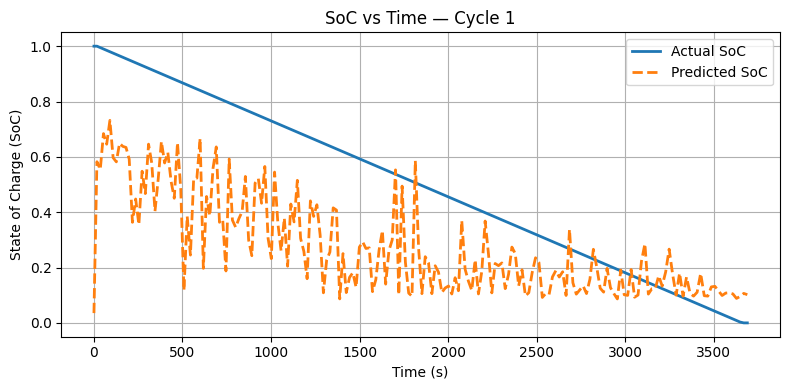

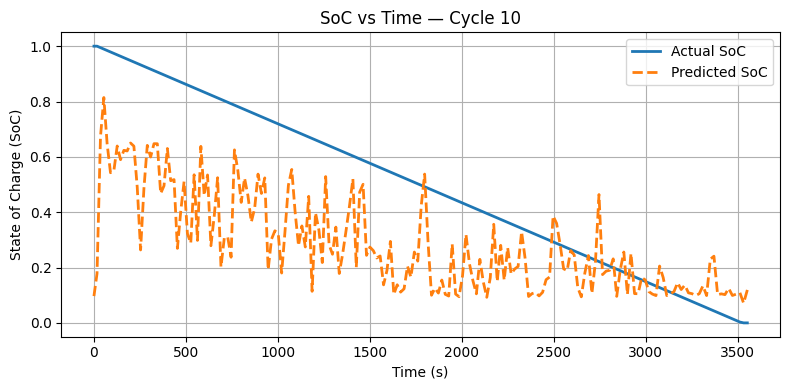

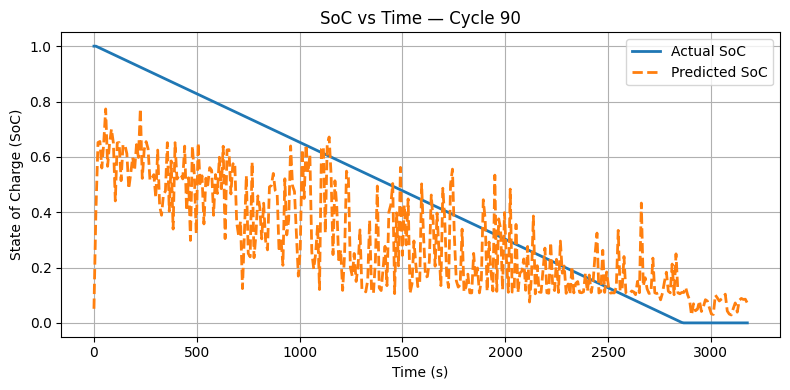

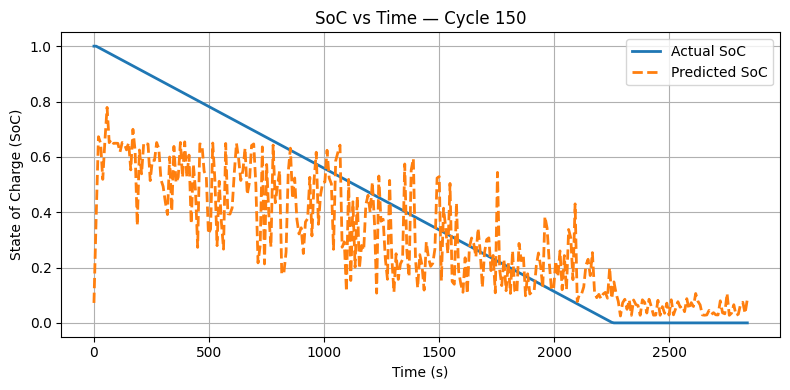

In [174]:
for cycle_id in [1, 10, 90, 150]:
    cycle_data = results_sorted[results_sorted['cycle'] == cycle_id]
    
    plt.figure(figsize=(8, 4))
    plt.plot(cycle_data['time'], cycle_data['SoC'], label='Actual SoC', linewidth=2)
    plt.plot(cycle_data['time'], cycle_data['PredSoC'], label='Predicted SoC', linestyle='--', linewidth=2)
    
    plt.title(f"SoC vs Time — Cycle {cycle_id}")
    plt.xlabel("Time (s)")  # Adjust unit if different
    plt.ylabel("State of Charge (SoC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()